In [20]:
import itertools
import numpy as np
import pandas as pd
import pickle as pkl
import requests
import seaborn as sns
import os

from matplotlib import pyplot as plt
from scipy.stats import uniform
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from typing import Any, Dict, List, Tuple
from xgboost import XGBClassifier

from microservice import IUMModel
from t_student_test import (
    load_data,
    get_buckets_indices,
    get_xgb_logreg_f1_scores,
    get_s_p,
    get_t,
    is_xgb_better,
    BUCKETS_CNT,
    T_ALPHA,
)

In [21]:
FEATURE_VERSION = 'v1'
FEATURE_PATH = f"features/{FEATURE_VERSION}/feature.csv"

FEATURES = [
    'number_of_advertisements',
    'number_of_tracks',
    'number_of_skips',
    'number_of_likes',
    'number_of_liked_tracks_listened',
    'number_of_tracks_in_favourite_genre',
    'total_number_of_favourite_genres_listened',
    'average_popularity_in_favourite_genres',
    'total_tracks_duration_ms',
    'number_of_different_artists',
    'average_release_date',
    'average_duration_ms',
    'explicit_tracks_ratio',
    'average_popularity',
    'average_acousticness',
    'average_danceability',
    'average_energy',
    'average_instrumentalness',
    'average_liveness',
    'average_loudness',
    'average_speechiness',
    'average_tempo',
    'average_valence',
    'average_track_name_length',
    'average_daily_cost'
]

TARGETS = [
    "premium_user_numerical",
    "will_buy_premium_next_month_numerical"
]

TARGET_AND_FEATURES = TARGETS + FEATURES


In [22]:
data_frame = pd.read_csv(FEATURE_PATH)

In [23]:
data_frame.head()

,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,number_of_liked_tracks_listened,number_of_tracks_in_favourite_genre,total_number_of_favourite_genres_listened,average_popularity_in_favourite_genres,total_tracks_duration_ms,number_of_different_artists,average_release_date,average_duration_ms,explicit_tracks_ratio,average_popularity,average_acousticness,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,212,2020,2,1,0,0,10,30,16,8,8,9,9,39.888889,7049696,27,4.125092e+08,234989.866667,0.000000,35.800000,0.322001,0.542767,0.600467,0.094653,0.179113,-10.158167,0.049070,121.964467,0.588167,22.233333,0.012134
1,212,2020,7,1,0,0,5,16,8,2,2,4,4,32.750000,4729508,15,4.745372e+08,295594.250000,0.062500,36.687500,0.159836,0.499000,0.675250,0.150966,0.226225,-8.795062,0.061812,123.069063,0.452131,22.687500,0.014780
2,212,2020,1,1,0,0,14,39,21,12,13,14,14,35.000000,9671215,36,4.789662e+08,247979.871795,0.025641,35.205128,0.186760,0.487000,0.691667,0.119363,0.235690,-9.491795,0.064918,123.745769,0.564369,19.461538,0.012399
3,212,2020,3,1,0,0,3,20,9,6,6,7,7,43.857143,4840993,18,4.264182e+08,242049.650000,0.000000,39.300000,0.285881,0.516700,0.637150,0.069641,0.189545,-8.409150,0.053715,121.415600,0.586000,21.250000,0.012706
4,212,2020,8,1,0,0,13,40,22,12,12,16,16,36.937500,9926300,35,4.311181e+08,248157.500000,0.000000,37.575000,0.318617,0.513525,0.642350,0.112645,0.285203,-9.562400,0.055282,120.922325,0.510517,24.000000,0.013076


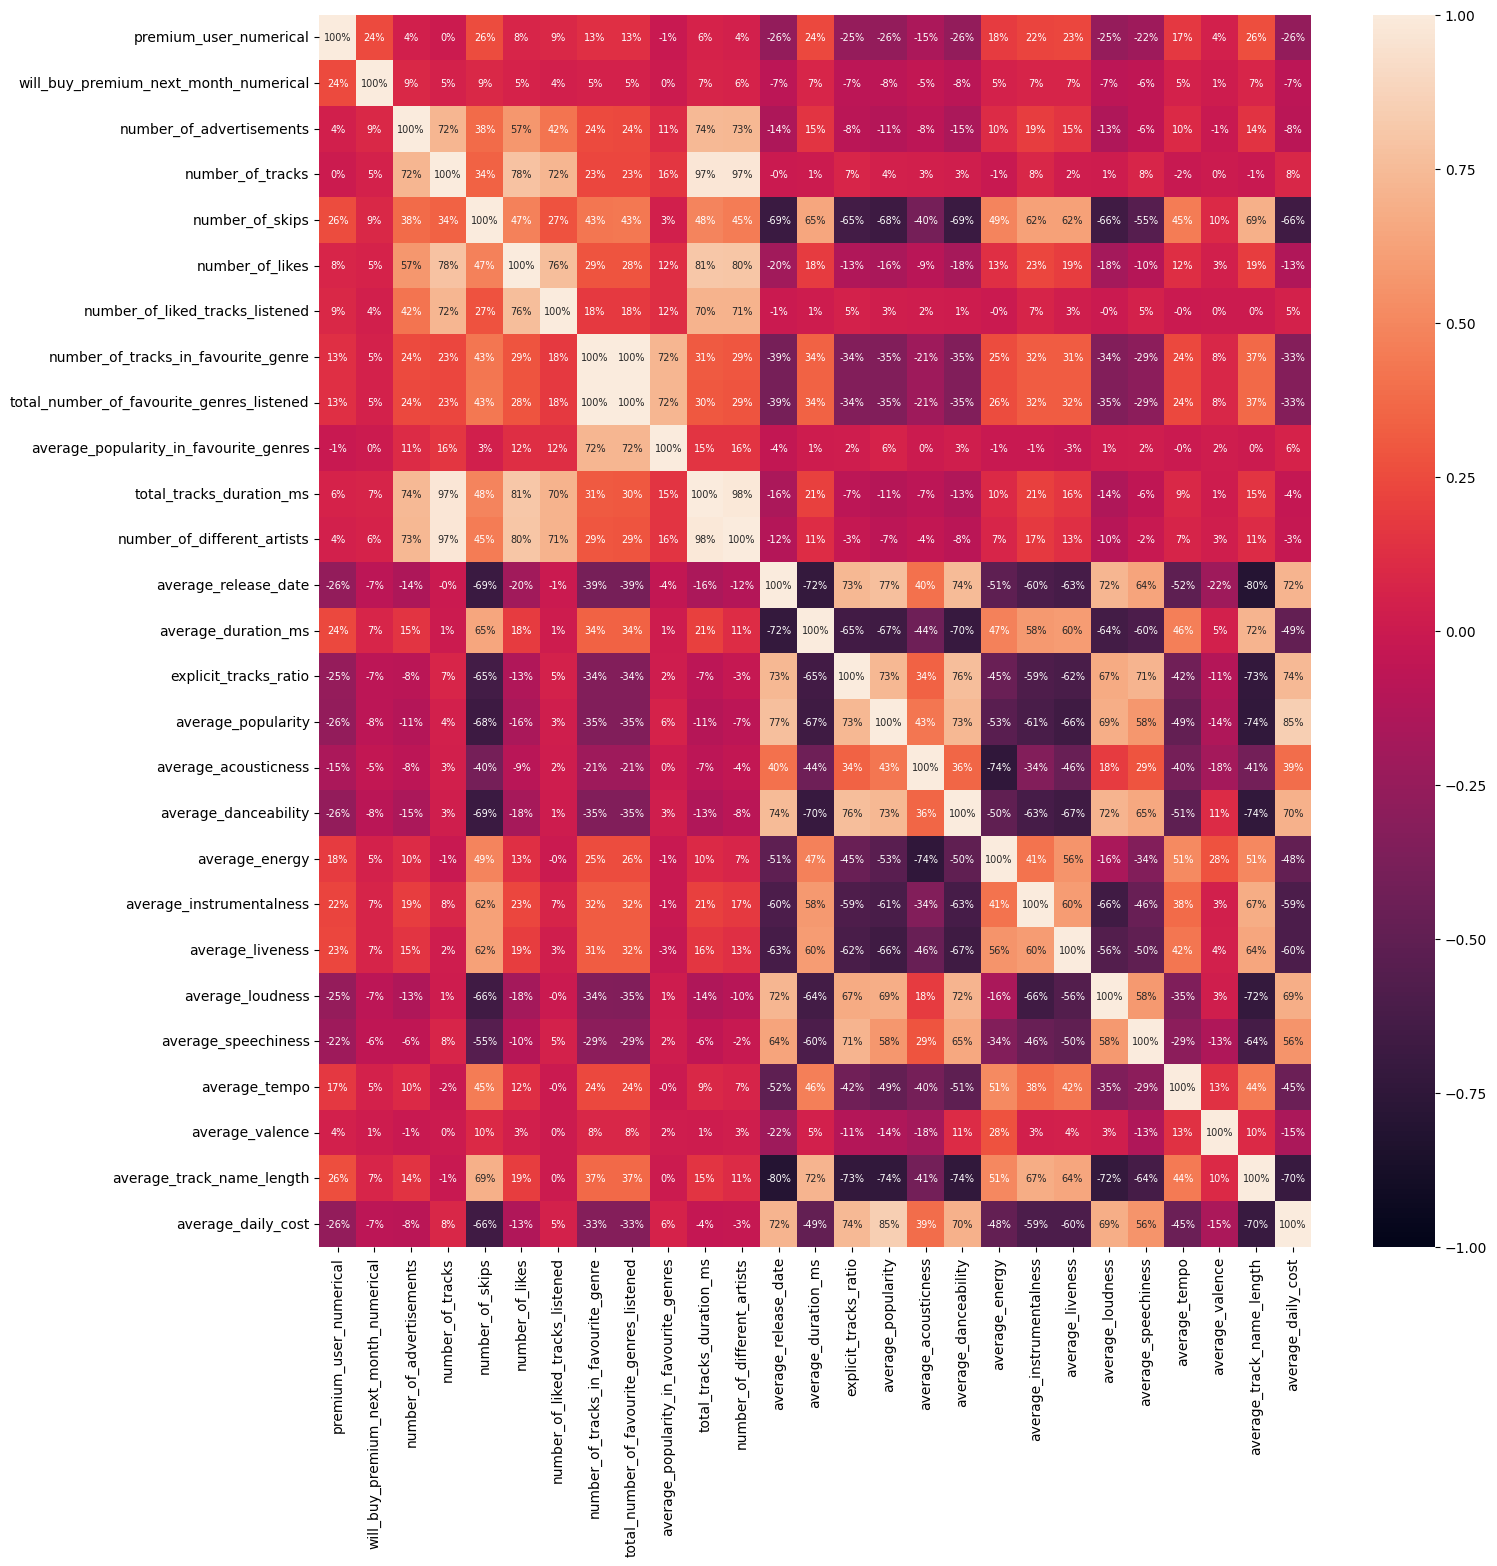

In [24]:
correlation_matrix = data_frame.loc[:, TARGET_AND_FEATURES].corr(method='spearman')

plt.figure(figsize = (16,16))

sns.heatmap(
    correlation_matrix,
    xticklabels=correlation_matrix.columns,
    yticklabels=correlation_matrix.columns,
    annot=True,
    annot_kws={"fontsize": 7},
    fmt=".0%",
    vmin=-1,
    vmax=1,
)

plt.show()

In [25]:
pipeline = Pipeline([("simple_imputer", SimpleImputer()), ("standard_scaler", StandardScaler())])

In [26]:
def get_preds_thr(y_proba: np.ndarray, thr: float) -> pd.Series:
    return pd.Series((y_proba[:, 1] > thr).astype(int))

def get_most_optimal_thr(y_train: pd.Series, y_train_proba: np.ndarray) -> float:
    thrs = np.arange(0, 1, 0.01)
    f1scores = dict()
    for thr in thrs:
        f1scores[thr] = f1_score(y_train, get_preds_thr(y_train_proba, thr))
    return max(f1scores, key=lambda x: f1scores[x])

In [27]:
TRAIN_DATA = data_frame.loc[data_frame.year < 2023, :]
TEST_DATA = data_frame.loc[data_frame.year >= 2023, :]
TEST_SIZE = 0.33

In [28]:
x_train, x_test, y_train, y_test = train_test_split(
    TRAIN_DATA[FEATURES], 
    TRAIN_DATA[TARGETS], 
    test_size=TEST_SIZE
)
data_train = pipeline.fit_transform(x_train)
data_test = pipeline.transform(x_test)
x_train = pd.DataFrame(data_train, columns=FEATURES)
x_test = pd.DataFrame(data_test, columns=FEATURES)

In [29]:
x_train.head()

,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,number_of_liked_tracks_listened,number_of_tracks_in_favourite_genre,total_number_of_favourite_genres_listened,average_popularity_in_favourite_genres,total_tracks_duration_ms,number_of_different_artists,average_release_date,average_duration_ms,explicit_tracks_ratio,average_popularity,average_acousticness,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,-1.356271,-1.366127,-0.879301,-0.533807,-0.704722,-0.642715,-0.610144,-1.010481,-1.427877,-1.460148,0.761997,-1.041654,1.994621,0.731052,-0.144231,0.314687,0.896490,-0.495524,-0.213321,1.308921,1.543900,-1.879375,-0.106607,-0.620334,0.024287
1,-0.857333,-0.974698,-0.879301,-0.812849,-0.704722,-0.642715,-0.610144,-1.010481,-1.135169,-0.860894,0.978640,-1.306253,1.994621,0.837966,1.958877,0.427409,-1.423850,-0.667266,-1.197335,0.478229,1.008831,-0.542197,-2.370948,-0.509997,1.156479
2,-0.607864,-0.583268,0.661563,-0.254764,-0.510245,-0.079338,-0.120541,-0.287090,-0.600025,-0.381490,-1.635576,-0.182187,-1.165195,-1.358951,-0.098045,-0.268945,0.900433,0.048009,0.915282,-0.357100,-0.973325,-0.340342,1.240788,0.858178,-1.330835
3,-1.605740,1.373878,-0.708094,0.861407,3.768260,-0.642715,-0.610144,-1.010481,1.001352,1.056719,0.962034,-0.783195,0.590258,0.827620,1.477643,0.579156,-1.032087,-0.991500,-0.715111,0.745324,0.950227,-0.279149,-0.309159,-1.054325,0.438082
4,0.140542,1.471736,-0.194473,0.582364,1.045575,0.859623,0.695464,1.441816,1.276223,0.817017,0.821594,-0.359643,0.030411,0.838712,0.347198,1.031003,-0.836917,-0.872032,-0.609275,0.781711,-0.129751,-1.515254,-0.022786,-0.680572,0.332261


In [30]:
CANDIDATES = 1

model = XGBClassifier()
randomized_search_cv = RandomizedSearchCV(
    estimator = model,
    param_distributions={
        "max_depth": np.arange(3, 30, 1),
        "eta": uniform(0, 0.1),
        "gamma": uniform(0, 1),
        "n_estimators": np.arange(10, 100, 1),
    },
    n_iter=CANDIDATES,
    scoring="f1",
    n_jobs=-1,
    verbose=3,
)

In [31]:
randomized_search_cv.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\mati2\Downloads\ium-23l-master\ium-23l-master\.venv\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99])},
                   scoring='f1', verbose=3)

F1 score for premium_user_numerical: 0.2613257904101465


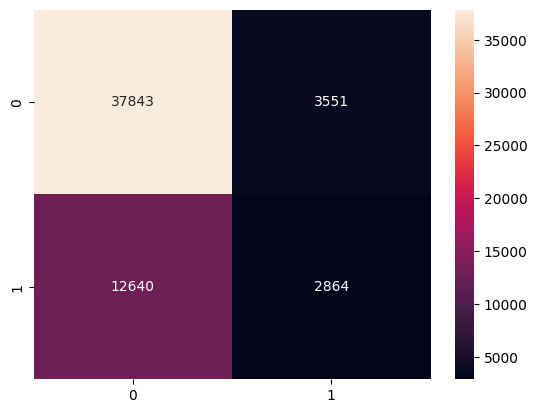

F1 score for will_buy_premium_next_month_numerical: 0.011884550084889643


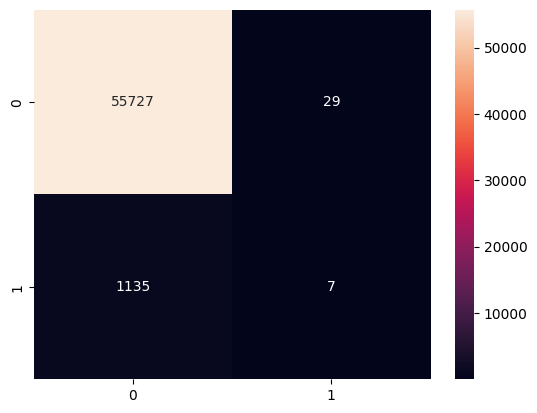

In [13]:
y_pred = randomized_search_cv.predict(x_test)
for i, target in enumerate(TARGETS):
    matrix_y_true = y_test[target]
    matrix_y_pred = y_pred[:, i]
    f1_score_value = f1_score(matrix_y_true, matrix_y_pred)
    print(f"F1 score for {target}: {f1_score_value}")
    matrix = confusion_matrix(matrix_y_true, matrix_y_pred)
    sns.heatmap(
        matrix, 
        annot=True, 
        fmt='g', 
        xticklabels=["0", "1"], 
        yticklabels=["0", "1"]
    )
    plt.show()

NotFittedError: need to call fit or load_model beforehand

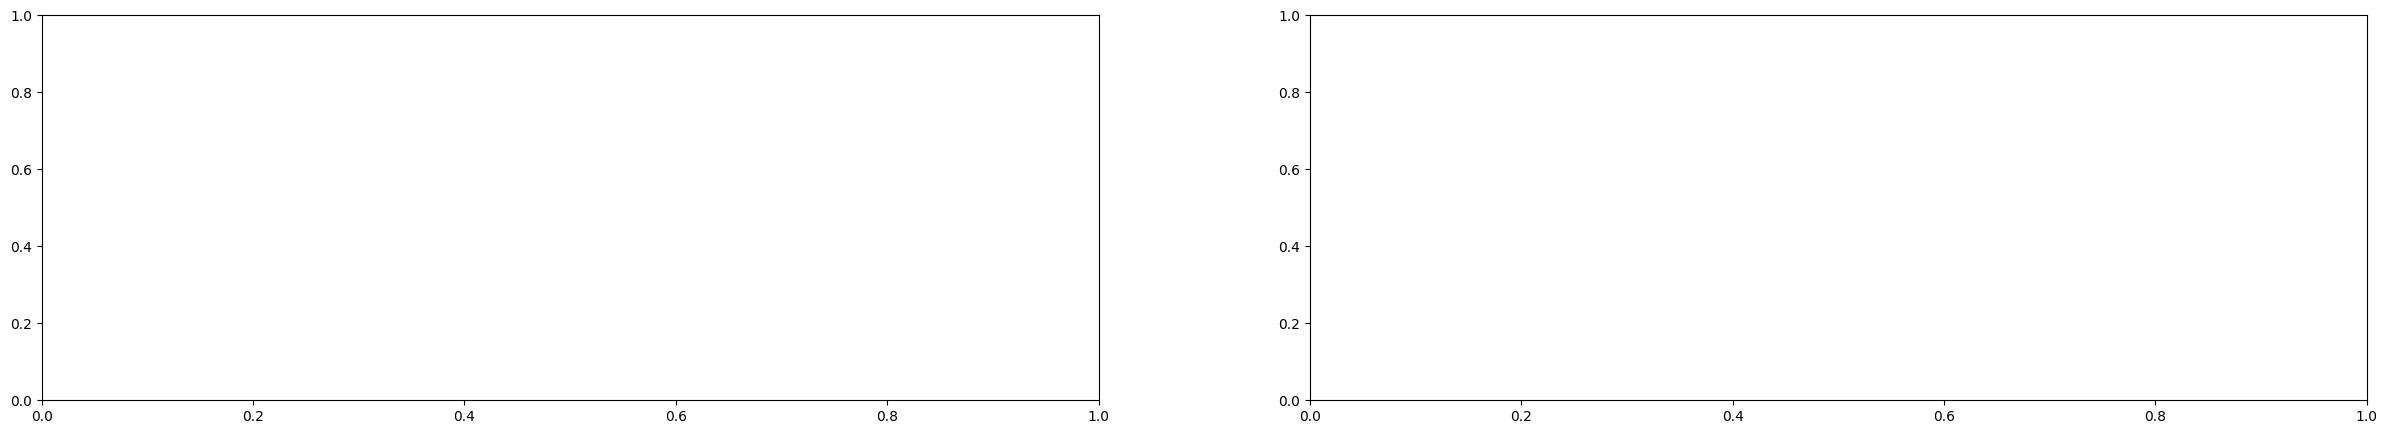

In [33]:
_, axs = plt.subplots(1, 2, figsize=(30, 5))
axs = axs.flatten()
idx = 0
for names, values, m_name in zip(
    [model.feature_names_in_, model.feature_names_in_],
    [model.coef_[0], model.feature_importances_],
    ["LogisticRegression", "XGBClassifier"],
):
    a = axs[idx]
    a.barh(y=names, width=values, edgecolor="black")
    a.bar_label(a.containers[0], fmt="%.2f")
    a.set_title(f"{m_name} feature importances")
    idx += 1
plt.show()

In [14]:
def get_class_weights(y: pd.Series, weights: List[float]) -> np.ndarray:
    return y.apply(lambda x: weights[x]).values


def train_score(
    model_class: Any,
    xgb_params: Dict[str, Any] = dict(),
) -> Tuple[List[float], Any, pd.DataFrame, pd.DataFrame]:
    _, axs = plt.subplots(2, 5, figsize=(40, 15))
    metrics = {
        "f1_score": [],
        "precision": [],
        "recall": [],
    }
    axs = axs.flatten()
    for month_ in np.arange(10) + 1:
        train_data = data_frame.loc[data_frame.month <= month_, :]
        test_data = data_frame.loc[data_frame.month == month_ + 1, :]
        X_train, y_train = train_data[FEATURES], train_data[TARGETS]
        X_test, y_test = test_data[FEATURES], test_data[TARGETS]
        X_train = pd.DataFrame(pipeline.fit_transform(X_train), columns=FEATURES)
        X_test = pd.DataFrame(pipeline.transform(X_test), columns=FEATURES)
        model = model_class(**xgb_params)
        model.fit(X_train, y_train)
        y_train_proba = model.predict_proba(X_train)
        thr = get_most_optimal_thr(y_train, y_train_proba)
        y_pred_proba = model.predict_proba(X_test)
        y_pred = get_preds_thr(y_pred_proba, thr)
        a = axs[month_ - 1]
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", ax=a)
        a.set_title(f"{month_} test")
        metrics["f1_score"].append(f1_score(y_test, y_pred))
        metrics["precision"].append(precision_score(y_test, y_pred))
        metrics["recall"].append(recall_score(y_test, y_pred))
    return metrics, model, X_test, y_test

In [34]:
def create_plot_from_model(x_train, y_train, x_test, y_test, subplots, model_constructor, model_params = dict()):
    data_train = pipeline.fit_transform(x_train)
    data_test = pipeline.transform(x_test)
    x_train = pd.DataFrame(data_train, columns=FEATURES)
    x_test = pd.DataFrame(data_test, columns=FEATURES)
    model = model_constructor(**model_params)
    model.fit(x_train, y_train)
    y_train_proba = model.predict_proba(x_train)
    # TODO: get_most_optimal_threshold
    thr = 0.2
    y_pred_proba = model.predict_proba(x_test)
    plots = []
    for i, target in enumerate(TARGETS):
        y_pred = pd.Series((y_pred_proba[:, i] > thr).astype(int))
        matrix_y_true = y_test[target]
        matrix_y_pred = y_pred
        f1_score_value = f1_score(matrix_y_true, matrix_y_pred)
        print(f"F1 score for {target}: {f1_score_value}")
        print(f"Precision: {precision_score(matrix_y_true, y_pred)}")
        print(f"Recall: {recall_score(matrix_y_true, y_pred)}")
        matrix = confusion_matrix(matrix_y_true, matrix_y_pred)
        sns.heatmap(
            matrix, 
            annot=True, 
            fmt='g', 
            xticklabels=["0", "1"], 
            yticklabels=["0", "1"],
            annot_kws={"fontsize": 40},
            ax=subplots[i]
        )
    return plots


F1 score for premium_user_numerical: 0.5675707135374229
Precision: 0.46069538926681786
Recall: 0.7390118217641709
F1 score for will_buy_premium_next_month_numerical: 0.08191126279863481
Precision: 0.32432432432432434
Recall: 0.046875
F1 score for premium_user_numerical: 0.4560058415480102
Precision: 0.34694444444444444
Recall: 0.6650692225772098
F1 score for will_buy_premium_next_month_numerical: 0.07894736842105264
Precision: 0.24324324324324326
Recall: 0.04712041884816754
F1 score for premium_user_numerical: 0.23745715176067306
Precision: 0.1483067341377968
Recall: 0.5953125
F1 score for will_buy_premium_next_month_numerical: 0.08484848484848485
Precision: 0.25925925925925924
Recall: 0.050724637681159424


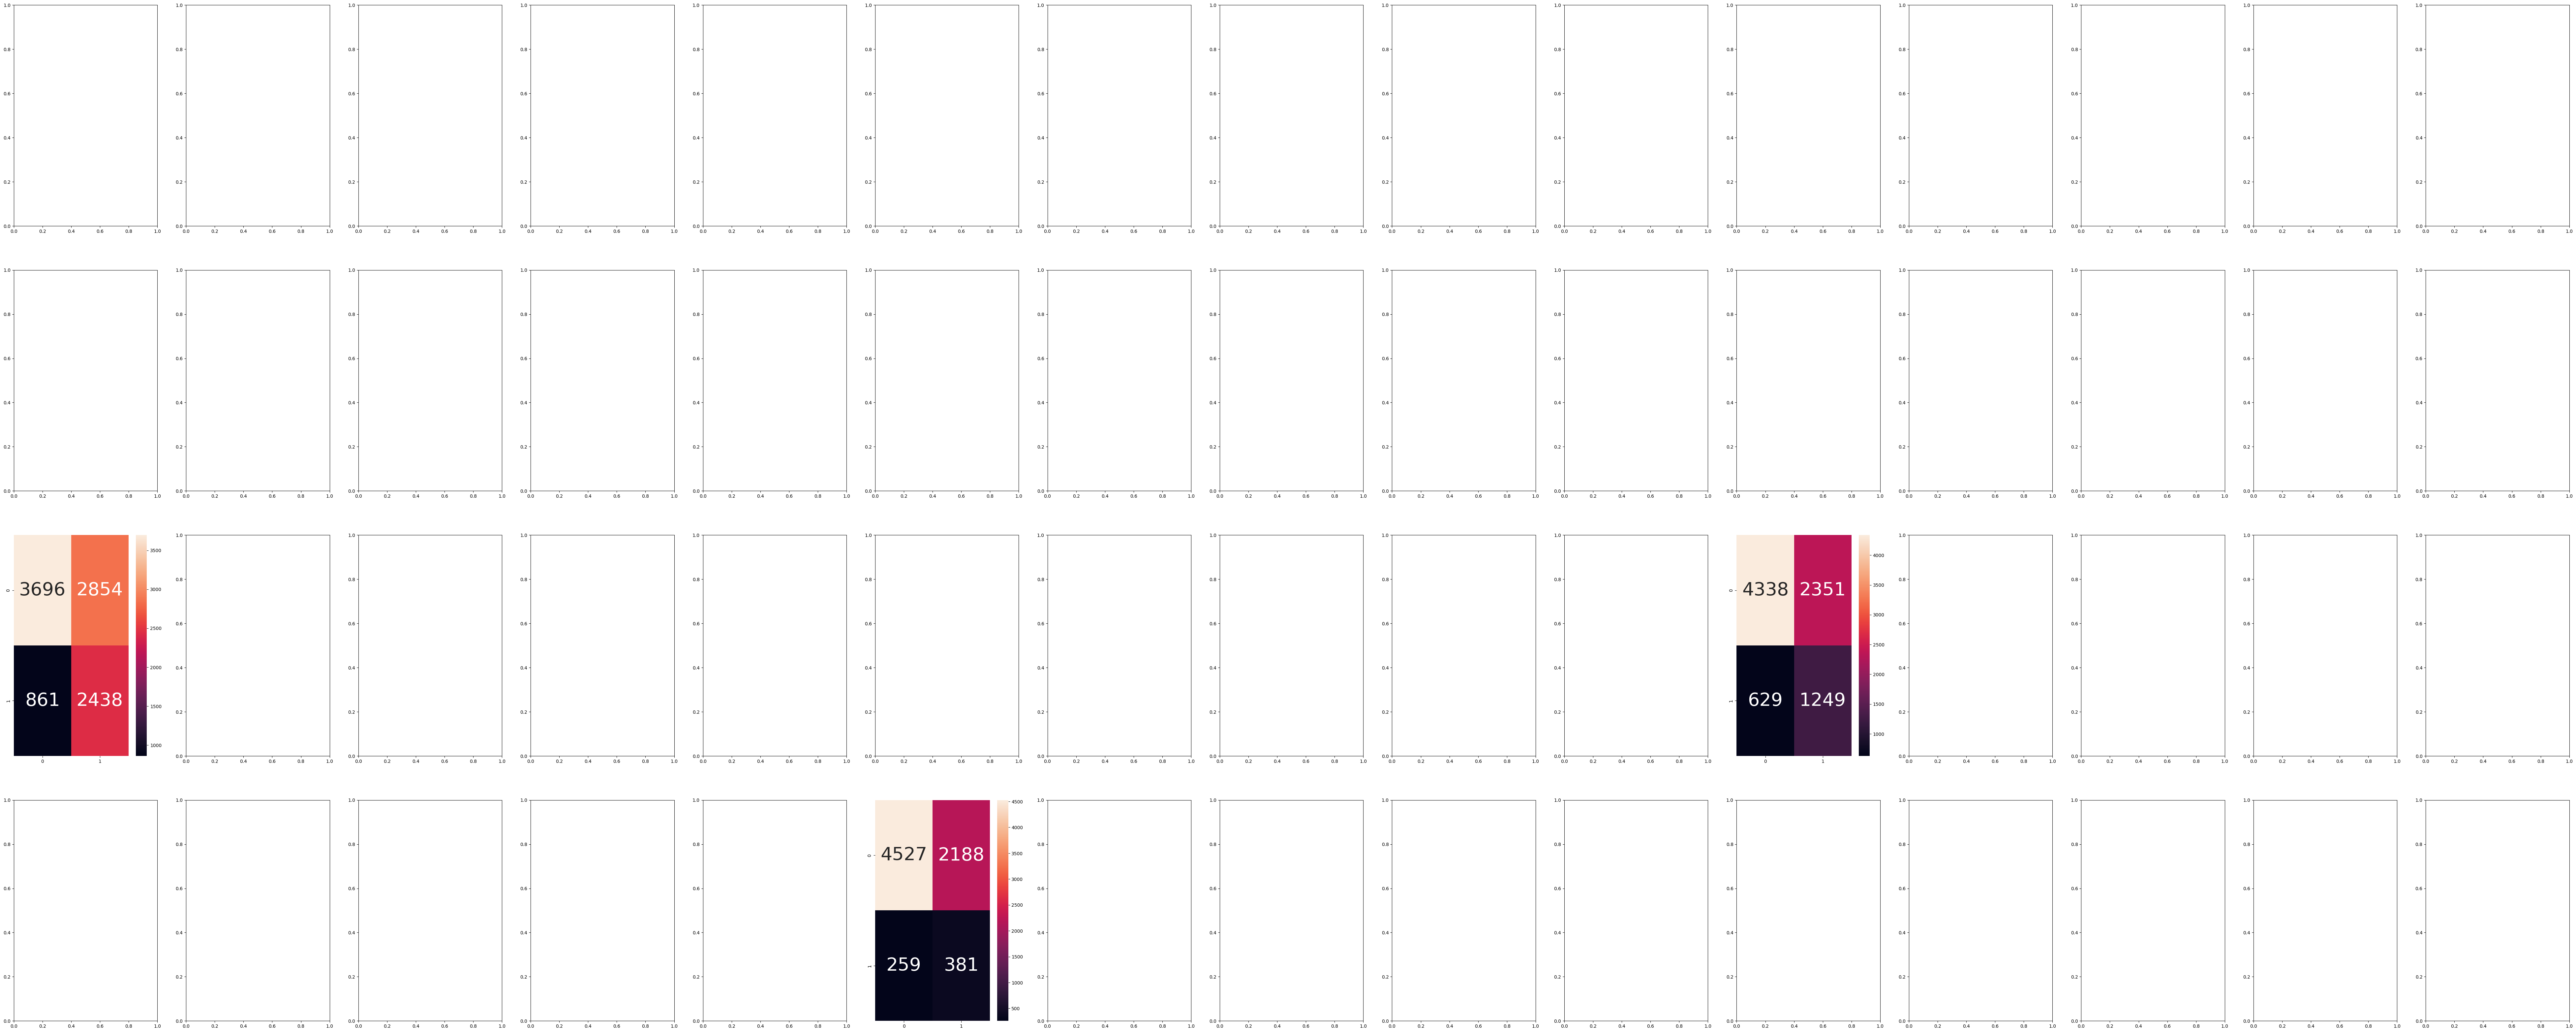

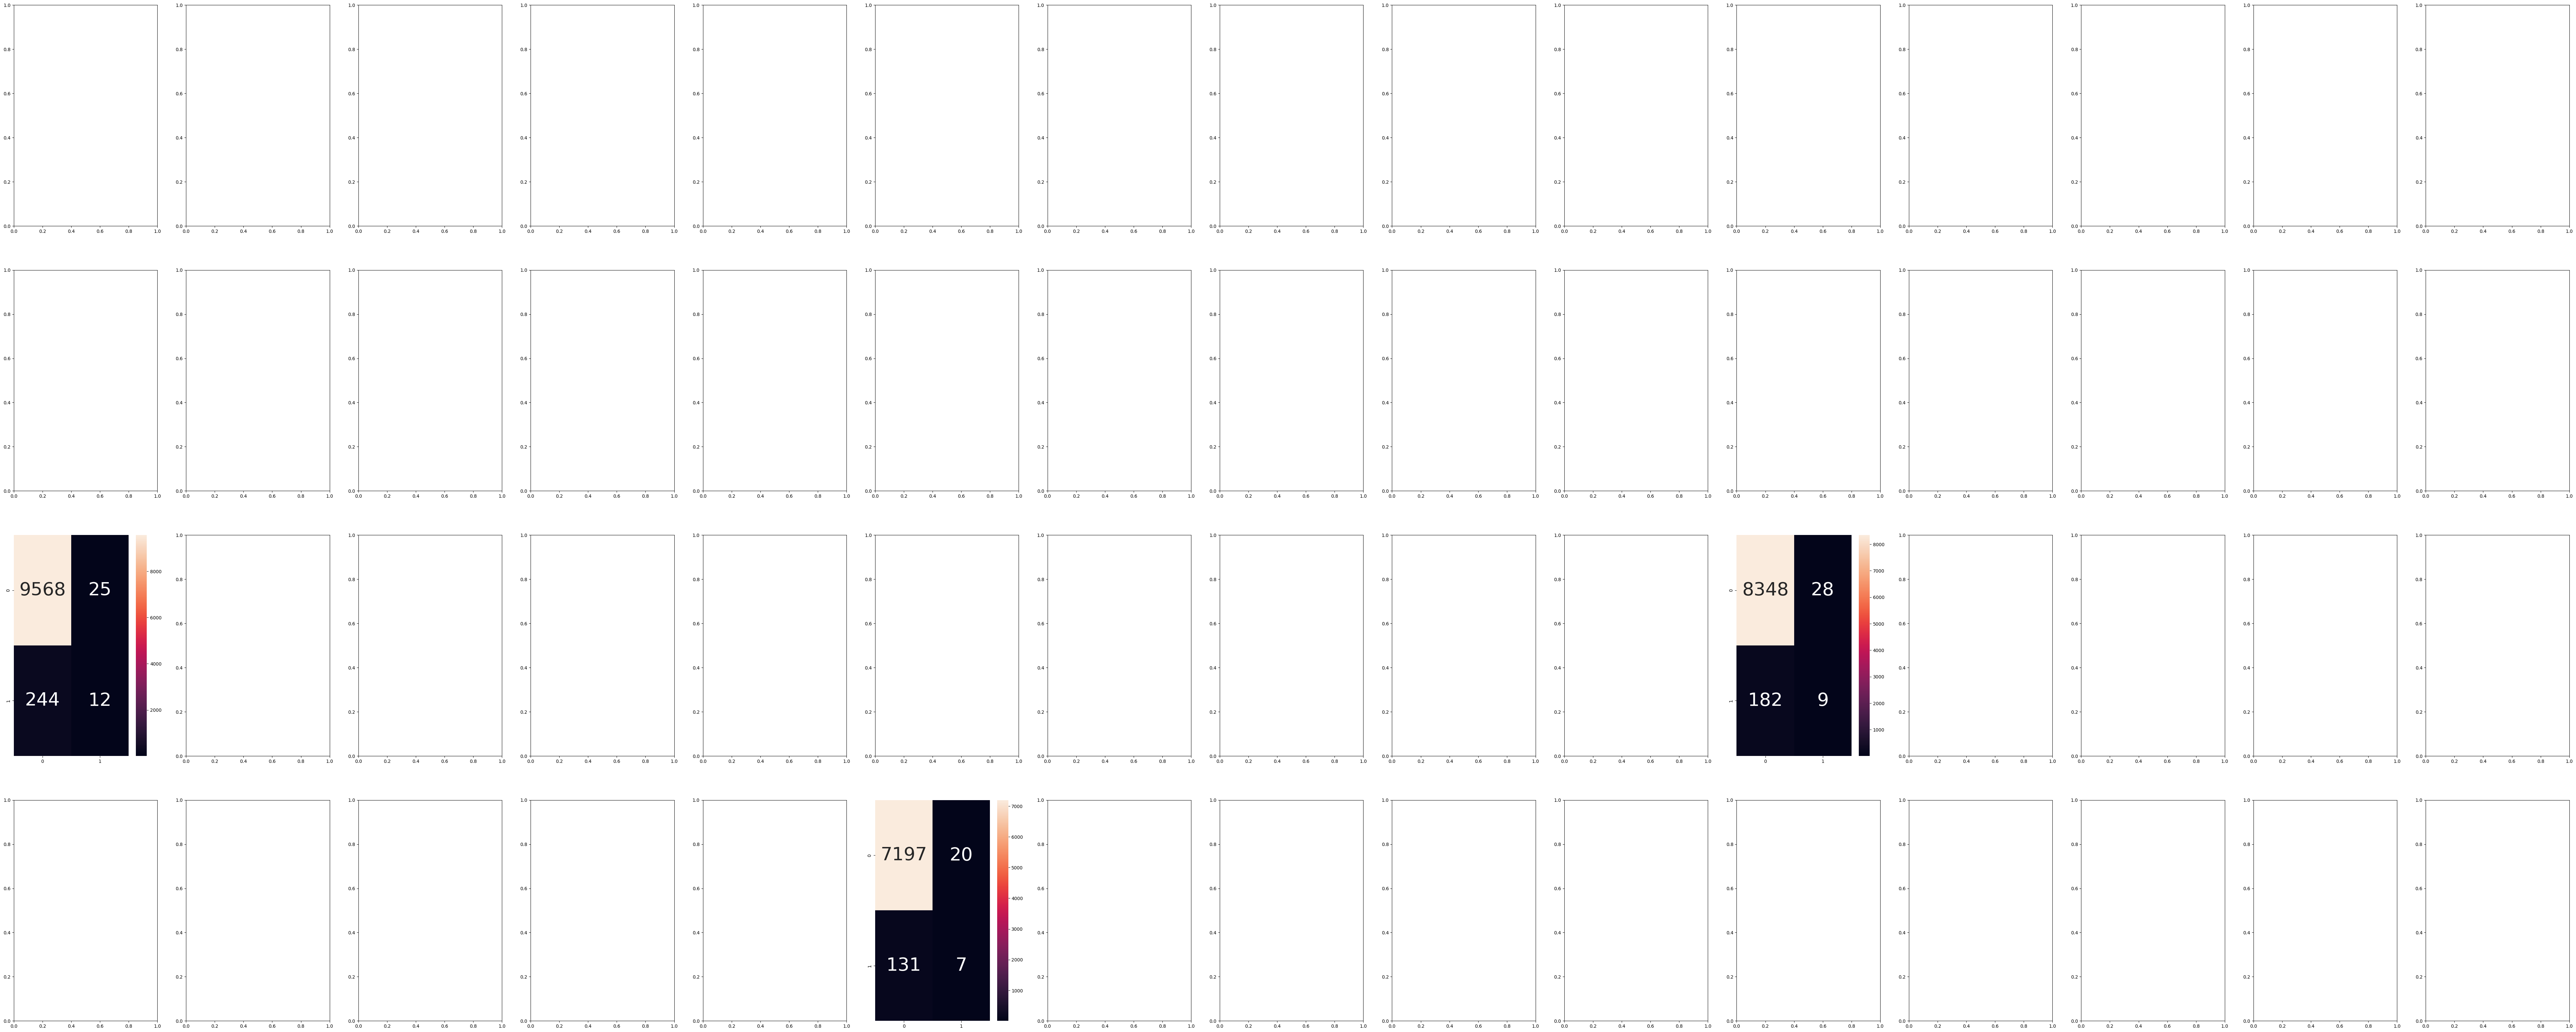

In [43]:
temp = 10
plots = []
MONTHS = 60
subplots = [plt.subplots(4, MONTHS//4, figsize=(100, 40))[1].flatten() for _ in TARGETS]
plot_statistics = []
for year, month in itertools.product(range(2019, 2023), range(1, 13)):
    temp += 1
    if temp % 10 != 0:
        continue
    data_train = data_frame.loc[
        data_frame.apply(lambda x: x.year < year or (x.month <= month and x.year == year), axis=1),
        :
    ]
    if len(data_train) == 0:
        continue
    data_test = data_frame.loc[
        data_frame.apply(lambda x: (x.month == month + 1 and x.year == year) or (x.year == year + 1 and x.month == 1), axis=1),
        :
    ]
    x_train, y_train = data_train[FEATURES], data_train[TARGETS]
    x_test, y_test = data_test[FEATURES], data_test[TARGETS]

    plots.append(create_plot_from_model(x_train, y_train, x_test, y_test, [subplot[temp] for subplot in subplots], XGBClassifier, randomized_search_cv.best_params_))

plt.show()

In [ ]:
# TODO: F1 score, Precision, Recall figures

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(30, 5))
axs = axs.flatten()
idx = 0
for names, values, m_name in zip(
    [logreg.feature_names_in_, xgb.feature_names_in_],
    [logreg.coef_[0], xgb.feature_importances_],
    ["LogisticRegression", "XGBClassifier"],
):
    a = axs[idx]
    a.barh(y=names, width=values, edgecolor="black")
    a.bar_label(a.containers[0], fmt="%.2f")
    a.set_title(f"{m_name} feature importances")
    idx += 1
plt.show()

In [3]:
def train(
    model_class,
    model_name: str = "",
    xgb_params = dict(),
) -> None:
    X_train, y_train = TRAIN_DATA[FEATURES], TRAIN_DATA[TARGETS]
    X_train = pd.DataFrame(pipeline.fit_transform(X_train), columns=FEATURES)
    model = model_class(**xgb_params)
    model.fit(X_train, y_train)
    y_train_proba = model.predict_proba(X_train)
    threshold = 0.2
    ium_model = IUMModel(pipeline, model, threshold)

    with open(f"models/{model_name}.pkl", "wb") as f:
        pkl.dump(ium_model, f)

In [32]:
train(XGBClassifier, "xgbclassifier", randomized_search_cv.best_params_)
# train(LogisticRegression, "logistic_regression")

In [ ]:
data_frame = pd.read_csv(FEATURE_PATH)

data_frame = data_frame.loc[data_frame.month == 11, :]

randomized_indices = np.random.permutation(data_frame.index)
A = data_frame.loc[randomized_indices[:int(0.5*len(data_frame))]]
B = data_frame.loc[randomized_indices[int(0.5*len(data_frame)):]]

In [ ]:
def perform_test(model, data):
    # Initiate empty DataFrame
    export = {"user_id": [], "guess": [], "ground_truth": [], "model": []}
    export = pd.DataFrame(export)
    # Go over all records
    for i in range(0, len(data)):
        # Extract one record
        row_vals = data.iloc[i]
        # Save the users id and the ground truth for future use
        user_id = row_vals.user_id
        ground_truth = row_vals.is_premium
        # Delete user id, month and is premium columns as they are unnecessary
        row_vals.drop('user_id')
        row_vals.drop('month')
        row_vals.drop('is_premium')
        # Extract only the values
        row_vals = row_vals.values
        # Prepare the request
        features = ','.join(map(str, row_vals))
        request = "http://127.0.0.1:8000/models/" + model + "?features=" + features
        # Get prediction from microservice
        guess = requests.get(request).json()
        # Append prediction to DataFrame
        line = pd.DataFrame({"user_id": [user_id], "guess": [guess["prediction"]], "ground_truth": [ground_truth], "model": [model]})
        export = pd.concat([export, line], ignore_index=True)
    return export

In [ ]:
xgb = perform_test("xgbclassifier", A)
logic = perform_test("logistic_regression", B)

In [ ]:
xgb.guess.value_counts()

In [ ]:
xgb.ground_truth.value_counts()

In [ ]:
logic.guess.value_counts()

In [ ]:
logic.ground_truth.value_counts()

In [ ]:
xgb.to_csv(os.path.join("results", "xgb.csv"), index=None)
logic.to_csv(os.path.join("results", "logic.csv"), index=None)

In [ ]:
print("f1", f1_score(xgb.ground_truth, xgb.guess))
print("f1", f1_score(logic.ground_truth, logic.guess))

In [ ]:
np.random.seed(1234)

print(f"{BUCKETS_CNT=}, {T_ALPHA=}")
data = load_data()
buckets_indices = get_buckets_indices(data.user_id.values)
xgb_f1_score, logreg_f1_score = get_xgb_logreg_f1_scores(data, buckets_indices)
print(f"{np.mean(xgb_f1_score)=}, {np.mean(logreg_f1_score)=}")
s_p = get_s_p(xgb_f1_score, logreg_f1_score)
t = get_t(xgb_f1_score, logreg_f1_score, s_p)
print(f"{s_p=}, {t=}")
if is_xgb_better(t):
    print("XGBClassifier is better than LogisticRegression")
else:
    print("We can't say that XGBClassifier is better than LogisticRegression")